# Neural networks and Reservoir Computing


## Введение 

В этой лекции мы рассмотрим следующие темы: 

- Оконные подходы и нелинейные модели для прогнозирования временных рядов. 
- Нейронные сети и многослойный перцептрон. 
- Краткий обзор рекуррентных нейронных сетей. 
- ESN, рандомизированная RNN из семейства Reservoir Computing. 
- Введение в уменьшение размерности с помощью анализа главных компонентов. 
- Примеры прогнозирования с помощью MLP и ESN на основе реальных данных об электроэнергии.

In [ ]:
import sys

# Install dependencies if the notebook is running in Colab
if 'google.colab' in sys.modules:
    !pip install -U -qq reservoir_computing

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.datasets import make_circles
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.utils import make_forecasting_dataset
from reservoir_computing.datasets import PredLoader

---

## Windowed approaches for prediction

— Эти методы рассматривают фиксированное окно размера $P$. 
- Используйте элементы временного ряда в окне $x(t-P), \dots, x(t-1), x(t)$ для вычисления прогноза $x(t+\tau)$, где $\tau$ — горизонт прогнозирования. 
- Различные алгоритмы по-разному комбинируют элементы окна для прогнозирования. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/Readout.png?raw=1" style="width: 40%; display: Block; Margin: auto;">

- По мере того как окно скользит по временному ряду, делаются новые прогнозы. 
- Примером оконного подхода является линейная AR-модель порядка $P$:
$$\hat y(t+1) = \beta_0 + \beta_1 x(t-1) + \beta_2 x(t-2) + \dots + \beta_P x(t-P)+\epsilon_t$$

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/sin.gif?raw=1" style="width: 40%; display: block; margin: auto;">

### Ограничение линейных моделей 

- Линейные модели широко используются из-за их простоты и понятности. 
- Однако они предполагают постоянную связь между входными и целевыми переменными. 
- По существу, они не могут эффективно уловить эти нелинейности и взаимодействия.

- Рассмотрим следующие примеры: 
1. Вычислите *положение* $y$ роботизированной руки, зная положения $x_1, x_2, \dots$ суставов. 
2. Вычислить траекторию $\dot{y}$ по угловым скоростям сочленений $\omega_1, \omega_2, \dots$. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/robot.png?raw=1" style="width: 40%; display: Block; Margin: auto;"> 

— Линейная модель не справится со второй задачей.

#### Пример: прогнозирование спроса на электроэнергию

- Это классический пример, когда линейные модели терпят неудачу.
- Спрос на электроэнергию часто регулируется сложными и нелинейными взаимодействиями с другими факторами.

**Температура и спрос**
- Связь между температурой и спросом на электроэнергию обычно нелинейна и может иметь U-образную кривую.
- Спрос низок при умеренных температурах, но резко возрастает при высоких или низких температурах из-за потребностей в отоплении и охлаждении.

**Время и спрос**
- Модели спроса значительно различаются в течение:
- дня (пиковые часы утром и вечером),
- недели (рабочие дни против выходных),
- года (лето против зимы).

### Преимущества нелинейных моделей 

- Нелинейные модели, такие как нейронные сети, SVM, древовидные методы и т. д., могут: 
   - моделировать нелинейные зависимости между спросом и такими факторами, как температура, точно отображая U-образную кривую, 
   - принимать во внимание взаимодействие между различными переменными, такими как совокупное влияние времени, праздников и температуры по требованию, 
   - адаптироваться к различным закономерностям и изменениям тенденций с течением времени, делая их более устойчивыми в динамичных средах. 

---

## Neural networks

- Нейронные сети — это мощные нелинейные модели, являющиеся *универсальными аппроксиматорами*, т. е. они могут научиться аппроксимировать любую функцию. 
- Основная идея: 
1. Сопоставьте данные с многомерным пространством (благослови размерность). 
2. Примените нелинейное преобразование. 
3. Данные становятся линейно разделимыми.

In [ ]:
def plot_3D(elev=20, azim=30):
    X, y = make_circles(n_samples=200, factor=.01, noise=.15)
    fig = plt.figure(figsize=(10, 5))
    r = np.exp(-(X ** 2).sum(1))
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='bwr', alpha=0.5)
    ax.view_init(elev=elev, azim=azim)
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
    zz = np.full(xx.shape, 0.6)
    ax.plot_surface(xx, yy, zz, color='grey', alpha=0.7)
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_zlabel("$z_3$")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_zticks(())
    ax2 = fig.add_subplot(1, 2, 1)
    ax2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr', alpha=0.5)
    ax2.set_xlabel("$x_1$")
    ax2.set_ylabel("$x_2$")
    ax2.set_xticks(())
    ax2.set_yticks(())
    plt.tight_layout()
    plt.show()

- На этом рисунке показано, как отображение данных из низкого измерения (2D) в более высокое измерение (3D) и применение нелинейной функции делает данные линейно разделяемыми гиперплоскостью.

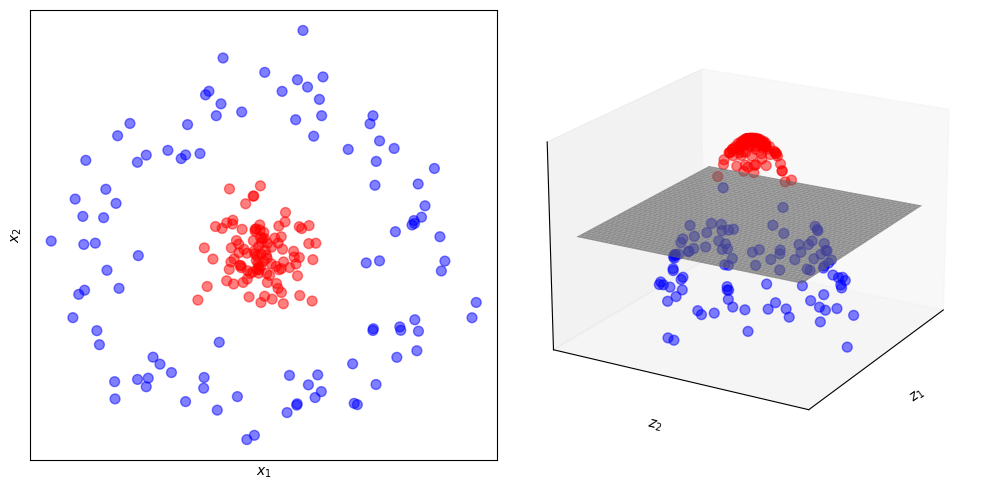

In [ ]:
plot_3D()

### Многослойный перцептрон 

- Многослойный персептрон (MLP) — это простая нейронная сеть, состоящая как минимум из трех слоев узлов: 
- Входной слой. 
- Один или несколько скрытых слоев. 
- An output layer.
 - Узлы скрытых слоев применяют нелинейную функцию активации $\sigma$. 
- MLP обычно обучают с помощью метода обучения с учителем, называемого обратным распространением ошибки.

- Уровни MLP полностью связаны, то есть каждый узел на одном уровне соединяется с определенным весом с каждым узлом на следующем уровне. 
- Первый уровень получает входные данные. 
- Выходные данные каждого слоя являются входными данными для следующего уровня, пока последний уровень не выдаст выходные данные MLP. 
- Веса хранятся в матрицах $W$ и являются обучаемыми параметрами модели. 
- MLP может изучать сложные сопоставления входных данных и выходных данных для выполнения широкого спектра задач моделирования и прогнозирования данных.

#### Пример: простой MLP 

- Давайте рассмотрим конкретный пример MLP с одним входным слоем, двумя скрытыми слоями (с модулями $h_1$ и $h_2$ соответственно) и одним выходным слоем. 
- Входные векторы имеют размер $d_\text{in}$, а выходные векторы имеют размер $d_\text{out}$. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/mlp.png?raw=1" style="width: 40%; display: Block; Margin: auto;">

**Входной слой** 
- Размер входного слоя соответствует размеру входных векторов, $d_\text{in}$. 
— Этот слой просто передает входные данные первому скрытому слою без применения каких-либо преобразований.

**Первый скрытый слой** 
- Этот слой имеет узлы $h_1$. 
- Каждый узел подключается ко всем входам $d_{\text{in}}$. 
- Он применяет весовую матрицу $W_\text{in} \in \mathbb{R}^{d_\text{in} \times h_1}$, которая преобразует входные данные векторов из $\mathbb{R}^{d_\text{in}}$ в векторы из $\mathbb{R}^{h_1}$. 
- Затем он применяет нелинейную функцию активации $\sigma$ и выводит промежуточные результаты $h_1$.

**Второй скрытый слой** 

- Этот слой имеет узлы $h_2$. 
- Он принимает выходные данные $h_1$ из первого скрытого слоя. 
- Он применяет другой набор весов и нелинейную функцию активации для получения промежуточных результатов $h_2$.

**Выходной слой** 
- Выходной слой имеет единицы измерения $d_\text{out}$. 
- Он берет выходные данные $h_2$ из второго скрытого слоя, применяет веса и, возможно, другую функцию активации, которая зависит от задачи (обычно softmax для классификации или отсутствие активации для регрессии). 
- Конечный выходной вектор имеет размер $d_\text{out}$.

### MLP для прогнозирования временных рядов 

- MLP можно использовать как оконный метод для прогнозирования временных рядов. 
- Последовательность прошлых значений $x(t-P),\dots, x(t-1), x(t)$ будет представлять наш входной вектор ($d_\text{in} = P$). 
- Будущее значение $x(t+\tau)$ будет результатом, который модель научится предсказывать ($d_\text{out} = 1$). 
- Мы также можем обучить MLP предсказывать последовательность $d_\text{out} = H$ будущих предсказаний, например, $x(t+\tau), x(t+\tau+1), \dots, x(t+\tau+H)$. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/mlp_windowed.png?raw=1" style="width: 40%; display: block; Margin: auto;">

- Ключом к обучению MLP является создание пар ввода-вывода $\{\mathbf{x}_i, \mathbf{y}_i\}$, используемых для обучения. 
- Учитывая входные данные $\mathbf{x}_i$, модель должна научиться прогнозировать выходные данные $\mathbf{y}_i$. 
- Это делается путем адаптации весов модели для минимизации несоответствия между прогнозом $\mathbf{\hat y}_i$ и желаемым результатом $\mathbf{y}_i$. 
- Веса изменяются в соответствии с градиентом, взятым относительно функции потерь $\mathcal{L}(\mathbf{\hat y}_i, \mathbf{y}_i)$, такой как MSE, например, $W \leftarrow W + \delta \frac{\partial \mathcal{L}}{\partial W}$. 
- $\delta$ — небольшая константа, определяющая шаг градиента (скорость обучения).

— Учитывая фрагмент временного ряда, используемый для обучения, обучающие выборки генерируются по схеме на рисунке. 
- Каждая пара ввода-вывода состоит из: 
- окно прошлых значений временных рядов $x(t-P), \dots, x(t-1), x(t)$. 
- окно будущих значений $x(t+\tau), x(t+\tau+1) \dots, x(t+\tau+H)$. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/data_split.png?raw=1" style="ширина: 100 %; дисплей: блок; поле: авто;">

### Пример Python 

- В этом примере мы рассмотрим временной ряд потребления электроэнергии, зарегистрированный в магистральной энергораспределительной сети Рима. 
- Исходный временной ряд имеет разрешение 10 минут. 
- В этом примере мы пересемплируем его до разрешения 1 час, так как оно станет более плавным (и его будет легче прогнозировать). 
— Чтобы быстрее обучать наши модели, мы будем рассматривать только первые «3000» образцов.

In [9]:
ts_full = PredLoader().get_data('ElecRome')

# Resample the time series to hourly frequency
ts_hourly = np.mean(ts_full.reshape(-1, 6), axis=1)

# Use only the first 3000 time steps
time_series = ts_hourly[0:3000]
time_steps = np.arange(0, len(time_series))

Loaded ElecRome dataset.
Data shape:
  X: (137376, 1)


- Далее мы разделяем данные на поезд и тестовый набор. 
- Мы просто используем первые 90% в качестве обучения, а остальные — в качестве теста.

In [10]:
# Split the time series into training and test sets
train_size = int(0.9*len(time_series))
tr = time_series[:train_size]
te = time_series[train_size:]

- Далее мы определяем функцию для создания пар ввода-вывода. 
— Например, мы создаем окна ввода размером $P=12$, указав `window_size=12`. 
- Аналогично создаем окна вывода размером `forecast_horizon=12`. 
- Если нас интересует предсказание только одной выборки, например, $\tau=12$ и $H=1$, мы просто берем последний элемент выходного окна.

In [11]:
def create_windows(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

# Define window size and forecast horizon
window_size = 12
forecast_horizon = 12

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

- Мы можем увидеть, как выглядят пары ввода-вывода на следующем графике. 
- Синие точки обозначают входные данные $x_{t-P}, \dots x_{t-1}, x_t$ с $P=12$. 
- Оранжевая точка — это выходной сигнал $x_{t+\tau}$ с $\tau=12$.

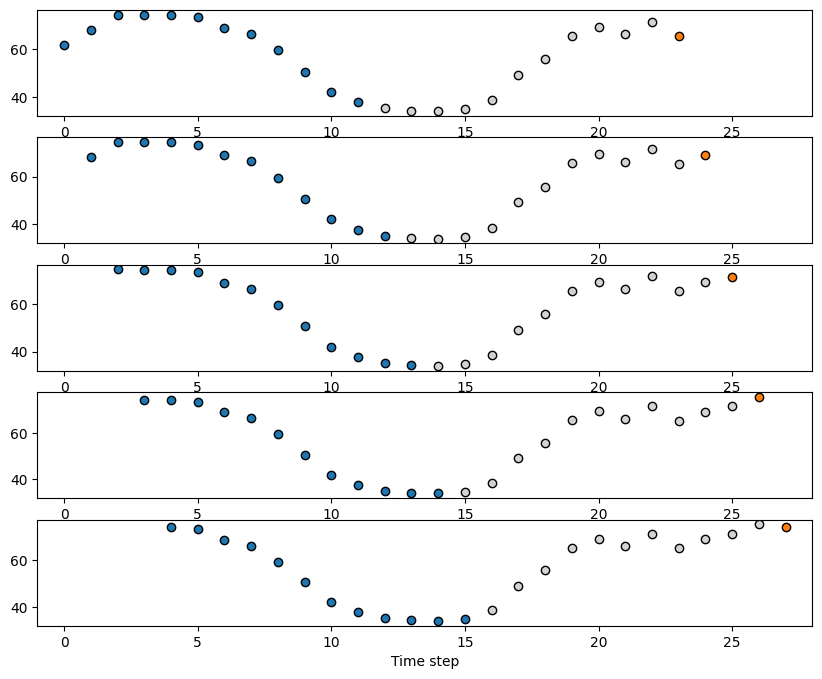

In [12]:
# Plot some pairs of input-output
fig, axes = plt.subplots(5,1,figsize=(10,8))
for i in range(5):
    axes[i].scatter(range(i, window_size+i), X_train[i], color='tab:blue', edgecolor='k')  # Input
    axes[i].scatter(range(window_size+i, i+window_size+forecast_horizon-1), y_train[i,:-1], color='lightgray', edgecolor='k')
    axes[i].scatter(i+window_size+forecast_horizon-1, y_train[i,-1], color='tab:orange', edgecolor='k')
    axes[i].set_xlim(-1,28)
plt.xlabel('Time step')
plt.show()

- Допустим, вместо этого мы хотим спрогнозировать потребление энергии на 1 день вперед, глядя на потребление за предыдущие 12 часов, что является более реалистичным сценарием. 
— Для этого мы определяем «forecast_horizon = 24».

In [13]:
# Define window size and forecast horizon
window_size = 12
forecast_horizon = 24

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

# We are only interested in the last time step of the horizon
y_train = y_train[:, -1]
y_test = y_test[:, -1]

— Большинство нейронных сетей, включая MLP, хотят, чтобы данные были нормализованы в небольшом диапазоне. 

— Мы можем сделать это, применив «StandardScaler()» из библиотеки sklearn. 

- `scaler.fit_transform(X_train)` вычитает из `X_train` его среднее значение и разделит на его дисперсию. 
- Scaler.transform(X_test) вычитает из X_test среднее значение X_train и делит на дисперсию X_train. 
- Почему бы не провести нормализацию со статистикой тестового набора? 
     - Поскольку у нас нет предварительного доступа к тестовым данным, мы не можем вычислить такую ​​статистику, как среднее значение и дисперсия.

In [14]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- Далее определяем МЛП. 
- Размер скрытых слоев указываем как $h_1=16$ и $h_2=8$. Использование больших значений увеличивает емкость модели, но может привести к переобучению. 
- В качестве функции активации мы используем [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). 
- В качестве алгоритмов расчета градиентов и обновления значений параметров $W$ мы используем [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam). 
- Наконец, мы обучаем модель на «1000» итераций.

In [15]:
# Define and train the neural network
mlp = MLPRegressor(hidden_layer_sizes=(16,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train_scaled, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(16, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True


- После обучения модели мы можем вычислить прогноз на тестовом наборе. 
- Мы также можем делать прогнозы, выходящие за рамки всего имеющегося у нас набора данных. 
— В этом случае у нас нет возможности проверить, насколько хорошо работает модель, поскольку у нас нет фактических данных. 
- Однако он отражает реалистичный сценарий прогнозирования, при котором мы действительно не знаем будущего.

In [16]:
# Predict on the test set
y_pred = mlp.predict(X_test_scaled)

# Forecast beyond the dataset using the model
last_window = time_series[-window_size:]
last_window_scaled = scaler.transform(last_window.reshape(1, -1))
next_step_pred = mlp.predict(last_window_scaled)

print(f"The next time step prediction is {next_step_pred[0]:.2f}")

The next time step prediction is 35.15


- Чтобы проверить производительность модели, мы можем вычислить MSE на основе прогнозов тестового набора. 
- Мы также можем визуализировать прогнозы на основе реальных данных.

Mean Squared Error: 28.04436954577414


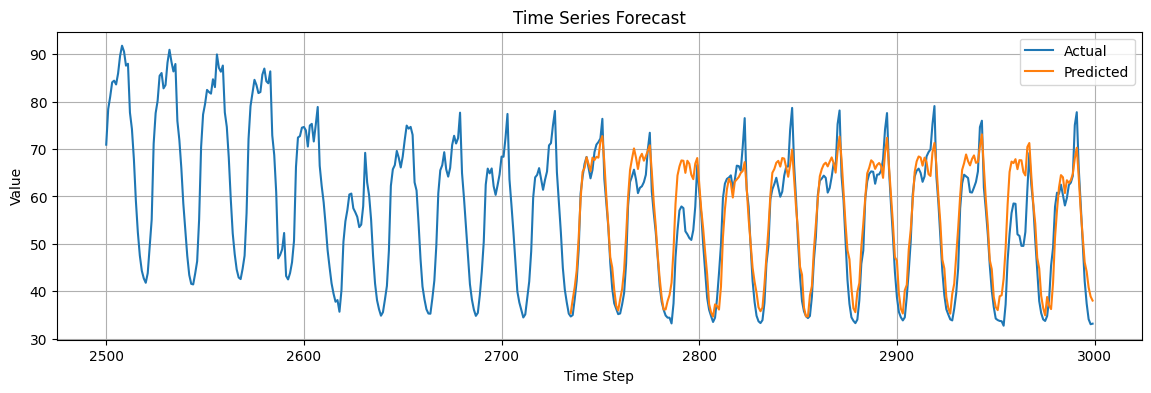

In [18]:
mse_mlp_original = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse_mlp_original}")

plt.figure(figsize=(14, 4))
plt.plot(time_steps[2500:], time_series[2500:], label="Actual")
plt.plot(time_steps[-len(y_test):], y_pred, label="Predicted")
plt.title("Time Series Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

- Прогноз хороший или нет? 
- Чтобы получить представление, мы можем сравнить производительность с простым базовым показателем. 
- В данном случае мы делаем прогноз на горизонте прогноза $\tau=24$, равном основной сезонности временного ряда. 
- Наиболее естественным базовым вариантом является использование значений предыдущего дня в качестве прогноза на следующий день.

Mean Squared Error: 27.14


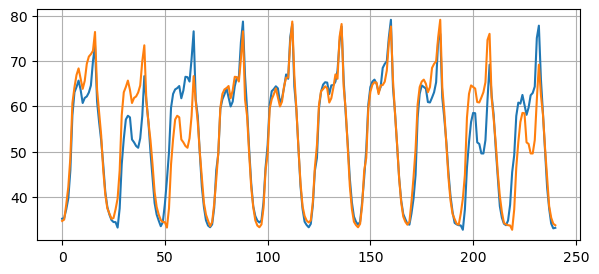

In [ ]:
# Compute the mse between the original time series and the time series shifhted by 24 time steps
mse = mean_squared_error(y_test[24:], y_test[:-24])
print(f"Mean Squared Error: {mse:.2f}")

plt.figure(figsize=(7, 3))
plt.plot(y_test[24:])
plt.plot(y_test[:-24])
plt.grid()
plt.show()

- Любой разумный метод прогнозирования должен превосходить этот бейзлайн.

### Недостатки оконного подхода 

- Каково оптимальное значение $P$? 
- Если $P$ фиксирован, как мы можем справиться с различными временными зависимостями? 
- Давайте рассмотрим пример предсказания следующего слова в предложении.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/word_pred.gif?raw=1" style="width: 50%; display: Block; Margin: auto;"> 

— В первом случае нам нужно вернуться на 4 временных шага назад, чтобы получить нужную нам информацию. 
- Во втором случае 9 шагов. 
- Как установить $P$? Какой максимальный объем памяти нам когда-либо понадобится? 
- Как обсуждалось ранее, установка слишком высокого значения $P$ приведет к слишком сильному сглаживанию наших данных. 
- Найти хороший компромисс сложно... 

---

## Recurrent Neural Networks

- RNN — это класс нейронных сетей, предназначенных для распознавания закономерностей в последовательностях данных, таких как данные временных рядов, естественный язык или последовательности изображений. 
- В отличие от традиционных нейронных сетей, RNN имеют память, которая фиксирует информацию о том, что уже было вычислено, что, по сути, позволяет им делать прогнозы на основе прошлых входных данных.

- Поскольку RNN обрабатывает последовательность $\mathbf{x}$, она сохраняет информацию в *скрытом состоянии* $\mathbf{h}$. 
- Этот процесс позволяет RNN использовать предыдущие вычисления в качестве контекста для принятия решений о новых данных. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/RNN.gif?raw=1" style="width: 70%; display: Block; Margin: auto;">

- $x(t)$ — входной временной ряд, $\mathbf{h}(t)$ — вектор скрытого состояния, $y(t)$ — выход. 
- Матрицы $W_x$, $W_h$ и $W_o$ представляют входные, скрытые (рекуррентные) и выходные веса соответственно.

**Обратное распространение во времени (BPTT)** 

— BPTT — это алгоритм, используемый для обучения RNN. 
- Он предполагает развертывание RNN во времени для получения стандартной нейронной сети прямого распространения (например, MLP). 
- После развертки можно применить стандартный алгоритм обратного распространения ошибки. 
- BPTT вычисляет градиенты для каждого параметра на *всех* временных шагах входной последовательности. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/bptt.png?raw=1" style="width: 50%; display: Block; Margin: auto;">

### Проблемы и недостатки RNN 

- В БПТТ градиент должен пройти все временные шаги и из-за наличия нелинейностей он может стать слишком малым и не достичь дальних временных шагов. 
- Это создает проблему под названием «исчезающий градиент». 
- Противоположной, но похожей является проблема *взрывного градиента*, возникающая, когда градиенты растут по всей последовательности. 
- Проблема исчезновения градиента затрудняет изучение долгосрочных зависимостей RNN, поскольку обновления весов становятся незначительно малыми, что приводит к остановке обучения. 
- И наоборот, взрывные градиенты могут привести к колебаниям или расхождению весов. 
- Для решения этих проблем были разработаны такие методы, как ограничение градиента и стробированные единицы (например, LSTM, GRU).

- Еще одним важным ограничением RNN является то, что они не могут использовать аппаратное ускорение, как другие нейронные сети. 
- Это связано с их повторяющимся характером, который требует выполнения вычислений последовательно, а не параллельно. 

---

## Reservoir Computing

- RC — это семейство рандомизированных RNN, популяризированное в машинном обучении сетью Echo State Networks (ESN). 
- Термины RC и ESN часто используются как взаимозаменяемые. 
- Есть два основных отличия, которые отличают ESN от RNN: 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/Reservoir.gif?raw=1" style="width: 70%; display: Block; Margin: auto;">

— Выходные веса $W_o$ — единственная обучаемая часть ESN. 
- Оптимизацию $W_o$ можно выполнить с помощью простого алгоритма линейной регрессии. 
- Порядок работы следующий.

1. Сгенерировать последовательность состояний резервуара $\mathbf{H} = \{\mathbf{h}(0), \mathbf{h}(1), \dots, \mathbf{h}(T)\}$. 
- Это делается путем применения уравнения обновления состояния
   
   $$\mathbf{h}_t = \sigma \left(\mathbf{W}_i x(t)+\mathbf{W}_h \mathbf{h}(t-1)\right)$$
   
- для каждого временного шага $t=1,2,\dots,T$ входной последовательности. 

- Нелинейность $\sigma$ обычно представляет собой гиперболический тангенс ($\texttt{tanh}$).

2. Применить алгоритм линейной регрессии для вычисления линейного отображения $g(\cdot)$ между состояниями резервуара и желаемой выходной последовательностью. $\mathbf{y} = \{y(1), y(2), \dots, y(T) \}$:

$$\mathbf{y} = g(\mathbf{H})$$

- Функция $g(\cdot)$ называется *чтение*. 
- В настройках прогнозирования $y(t)$ соответствует будущему значению входных данных, например:  $y(t) = x(t+\tau)$.

### Считывание 

- Показания $g(\cdot)$ обычно реализуются с помощью модели линейной регрессии, например, ридж-регрессии. 
- В этом случае $g(\cdot)$ соответствует весовой матрице $\mathbf{W}_o$. 
- Однако для реализации считывания можно использовать любую другую регрессионную модель, включая MLP. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/Readout.png?raw=1" style="width: 50%; display: Block; Margin: auto;">

- Обратите внимание, что подгонка MLP к состояниям считывания отличается от подхода к окну, который мы видели ранее. 
- Оконный подход: 
- Модель прогнозирует будущее значение на основе фиксированного объема временной информации, содержащейся в окне.
  
  $$x(t+\tau) = g([x(t-P), \dots, x(t-1), x(t)])$$

- Подход к резервуару: 
- Модель прогнозирует будущую стоимость на основе одного состояния резервуара.
  
  $$x(t+\tau) = g(\mathbf{h}(t))$$

### Почему резервуарный подход работает 

- Резервуар извлекает из временного ряда богатые динамические характеристики пула. 
- Они встроены в многомерное состояние Резервуара $\mathbf{h}(t)$. 
- В отличие от фиксированного окна, $\mathbf{h}(t)$ сохраняет память обо всех предыдущих входных данных, начиная с начала ряда $x(0)$. 
- Некоторые функции подходят для поставленной задачи, а другие нет. 
— Задача считывания — выбрать те признаки, которые актуальны для задачи.

- Допустим, мы хотим сделать прогноз на $\tau_1$ шагов вперед. 
- Считывание выберет определенную комбинацию динамических характеристик Резервуара. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/Reservoir_pred1.png?raw=1" style="width: 50%; display: block; Margin: auto;">

- Чтобы спрогнозировать на другом горизонте $\tau_2$, показания выберут другую группу объектов. 
- Обратите внимание, что в обоих случаях Readout всегда выдает один и тот же набор функций! 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/Reservoir_pred2.png?raw=1" style="width: 50%; display: Block; Margin: auto;">

- Показание необучено, и его состояния генерируются без *контроля*, т. е. без внешнего руководства. 
- Поскольку он не знает, какую задачу ему предстоит решить, Readout настроен на создание максимально богатого и разнообразного пула динамических функций. 
- Другими словами, Readout компенсирует отсутствие обучения избыточностью сгенерированных функций.

### Конфигурация резервуара 

— В резервуаре можно настроить несколько гиперпараметров. 
- Ниже мы рассмотрим основные из них.

#### Спектральный радиус 

- Очевидно, вклад более поздних результатов должен иметь более сильное влияние на текущее состояние. 
- Это значит, что Водохранилище должно постепенно забыть свое прошлое состояние. 
- Это свойство, называемое *свойством состояния эха*, дает имя сети состояния эха. 
- Это позволяет не моделировать шум, забыть о спорадических толчках и неинформативном начальном состоянии $\mathbf{h}(0)$. 
- В теории управления это означает наличие *сжимающей* динамики. 
- Динамика является сжимающей, если два изначально разных состояния в конечном итоге сходятся.

- С другой стороны, мы хотим, чтобы Резервуар имел богатый набор функций. 
- Если динамика Резервуара слишком *сжимающая*, этого не произойдет. 
- Нам нужно найти золотую середину, настроив параметр $\rho$, называемый *спектральный радиус*.

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/dynamics.png?raw=1" style="width: 50%; display: block; margin: auto;">

- Вспомните уравнение обновления состояния.

$$\mathbf{h}(t) = \sigma \left(\mathbf{W}_i x(t)+\mathbf{W}_h \mathbf{h}(t-1)\right)$$

- Спектральный радиус - это наибольшее собственное значение матрицы перехода состояний.$W_h$.
- Мы можем *установить* спектральный радиус $W_h$,, вычислив наибольшее собственное значение $\lambda_\text{max}$, а затем позволив $W_h = \rho \frac{W_h}{\lambda_\text{max}}$.

— Эмпирическое правило — устанавливать $\rho$ чуть ниже 1. 
- Однако для достижения хорошей производительности часто необходимо точно настроить $\rho$ до значений, которые могут быть ниже или даже выше 1.

- Другой способ определить правильное значение $\rho$ — посмотреть на *переходную* фазу Резервуара. 
- Именно столько времени нужно, чтобы забыть инициализацию. 
- Предположим две разные инициализации состояния Резервуара: $\mathbf{h}_1(0)$ и $\mathbf{h}_2(0)$. 
- Если динамика Резервуара сжимается, эффект от различных инициализаций со временем исчезнет. 
- Если это хаотично, то оно сохранится.

- Давайте проверим это на практическом примере. 
- Мы рассматриваем две инициализации: $\mathbf{h}_1(0) = [0,0,\dots,0]$ и $\mathbf{h}_2(0) = [1,1,\dots, 1]$. 
- В этом примере мы установили входное значение $x$ всегда равным нулю, чтобы оно не влияло на эволюцию состояния резервуара.

In [ ]:
# Initial states
initial_state_0 = np.zeros((1, 100), dtype=float)
initial_state_1 = np.ones((1, 100), dtype=float)

x = np.zeros((1, 100, 1)) # Zero input, it does not contribute to the state
rhos = [.3, 0.99, 1.3]    # We will use three different spectral radii

In [ ]:
def plot_states_evolution(x, rhos, h0, h1):
    plt.figure(figsize=(5, 3))
    for rho in rhos:
        res = Reservoir(spectral_radius=rho) # initialize the reservoir with a given spectral radius
        states_0 = res.get_states(x, bidir=False, initial_state=h0) # states using initial state 0
        states_1 = res.get_states(x, bidir=False, initial_state=h1) # states using initial state 1
        plt.plot(np.linalg.norm(states_0 - states_1, axis=(0,2)), label=f'rho={rho}') # L2 norm of the difference
    plt.legend(loc='upper right', ncol=3)
    plt.xlabel('$t$')
    plt.ylabel('$\|\mathbf{h}_1(t) - \mathbf{h}_2(t)\|_2$')
    plt.grid()
    plt.tight_layout()
    plt.title('Transient phase of the Reservoir')
    plt.show()

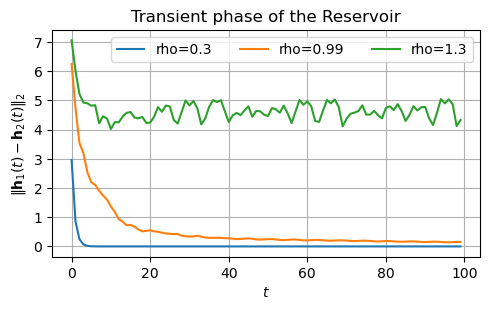

In [ ]:
plot_states_evolution(x, rhos, initial_state_0, initial_state_1)

#### Масштабирование ввода 

- Еще одним критическим значением является масштабирование входных данных $\omega_\text{in}$. 
- Это значение, которое умножает входные веса $W_i$, изменяя их величину. 
- Это ключ к контролю степени нелинейности в модели.

- Резервуарные установки обычно оснащены активацией $\texttt{tanh}$. 
- Небольшое значение $\omega_\text{in}$ сопоставляет входы резервуара с центром $\texttt{tanh}$, где они более линейны. 
- Таким образом, небольшое значение $\omega_\text{in}$ уменьшает степень нелинейности в Резервуаре. 
- С другой стороны, большое значение $\omega_\text{in}$ приводит к более нелинейному поведению, поскольку $\texttt{tanh}$ приближается к насыщению. 

<img src="https://github.com/fmi-ml-courses/ts-magi-2025-2026/blob/main/data/l10/tanh.png?raw=1" style="width: 30%; display: Block; Margin: auto;">

- Как и в случае со спектральным радиусом, $\omega_\text{in}$ следует настраивать тщательно. 
- Хорошее начальное значение обычно составляет около 0,1.

- Еще одним гиперпараметром является количество единиц Резервуара $N_h$. 
- Большее значение может дать лучшую производительность за счет увеличения времени вычислений. 
- Хорошей отправной точкой обычно является $N_h=300$, которую следует увеличивать до тех пор, пока не перестанет увеличиваться производительность.

- В ESN есть и другие гиперпараметры, такие как разреженность показаний и дополнительный шум, который можно ввести в уравнение обновления состояния. 
- Обычно они менее критичны, чем $\rho$ и $\omega_\text{in}$, и в большинстве случаев их можно оставить по умолчанию. 
- Настройка гиперпараметров в рандомизированных архитектурах, таких как ESN, гораздо важнее, чем в обучаемых нейронных сетях, поскольку нет обучения, способного компенсировать плохо инициализированные модели. 

---

## Пример Python: прогнозирование нагрузки на электроэнергию с помощью ESN 

- В дальнейшем мы будем использовать [библиотеку Python](https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing) `reservoir-computing`. 
- Библиотека позволяет нам выполнять классификацию временных рядов, кластеризацию и прогнозирование с помощью Reservoir Computing. 
- В этой лекции мы сосредоточимся на *прогнозировании*.

### Загрузите данные 

Перезагружаем тот же временной ряд энергетической нагрузки, который использовали ранее.

In [19]:
ts_full = PredLoader().get_data('ElecRome')

# Resample the time series to hourly frequency
ts_hourly = np.mean(ts_full.reshape(-1, 6), axis=1)[:, None]

# Use only the first 3000 time steps
time_series = ts_hourly[0:3000, :]

Loaded ElecRome dataset.
Data shape:
  X: (137376, 1)


— Для обучения ESN нам нужны входные и целевые данные «Xtr» и «Ytr». 
- Нам также нужны тестовые данные Xte и Yte для проверки модели и данные проверки Xval и Yval, если нам нужно выполнить настройку гиперпараметров. 
- Мы будем использовать функцию «forecasting_datasets», которая с учетом временного ряда «X» выполняет следующие вычисления.

1. Разбивает набор данных на последовательные фрагменты: «train», «val» и «test». 
    - Размер блоков задается значениями `val_percent` и `test_percent`. 
    - Если нам не нужны данные проверки, установите `val_percent=0` (по умолчанию), и данные проверки не будут созданы.

2. Создайте входные данные «X» и целевые данные «Y», сдвигая временные шаги «горизонта» данных, где «горизонт» — это то, насколько далеко мы хотим спрогнозировать. 
- Например: 
   - `Xtr = train[:-horizon,:]` 
   - `Ytr = поезд[горизонт:,:]`

1. Нормализует данные с помощью масштабатора из `sklearn.preprocessing`. 
- Если масштабаторы не переданы, создается StandardScaler. 
- Масштабировщик устанавливается на Xtr и затем используется для преобразования Ytr, Xval и Xte. 
- Обратите внимание, что `Yval` и `Yte` **не** преобразуются.

- Код ниже иллюстрирует использование функции. 
- Обратите внимание, что мы теряем некоторые данные из-за разделения и смещения.

In [20]:
X = np.arange(36)[:, None]
Xtr, Ytr, Xte, Yte, Xval, Yval, scaler = make_forecasting_dataset(X, horizon=5,
                                                                  test_percent=0.2,
                                                                  val_percent=0.3)
print("Xtr: ", scaler.inverse_transform(Xtr.T)[0])
print("Ytr: ", scaler.inverse_transform(Ytr.T))
print("Xval: ", scaler.inverse_transform(Xval.T)[0])
print("Yval: ", Yval.T)
print("Xte: ", scaler.inverse_transform(Xte.T)[0])
print("Yte: ", Yte.T)

Xtr:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
Ytr:  [[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]]
Xval:  [17. 18. 19. 20. 21. 22.]
Yval:  [[22 23 24 25 26 27]]
Xte:  [28. 29. 30.]
Yte:  [[33 34 35]]


— Вернемся к нашим реальным данным: мы хотим сделать прогноз на 24 часа вперед. 

— В реальном случае использования мы должны оптимизировать гиперпараметры в наборе проверки. 

— Однако, поскольку это всего лишь демонстрация, мы будем использовать гиперпараметры по умолчанию. 

— Поэтому мы оставляем значение по умолчанию `val_percent=0` и набор проверки не создается.

In [21]:
# Generate training and test datasets
Xtr, Ytr, Xte, Yte, scaler = make_forecasting_dataset(time_series,
                                                      horizon=24, # forecast horizon of 24h ahead
                                                      test_percent = 0.1)
print(f"Xtr shape: {Xtr.shape}\nYtr shape: {Ytr.shape}\nXte shape: {Xte.shape}\nYte shape: {Yte.shape}")

Xtr shape: (2676, 2)
Ytr shape: (2676, 1)
Xte shape: (276, 2)
Yte shape: (276, 1)


### Определите Reservoir(резервуар) и вычислите состояния 

- Сначала мы указываем гиперпараметры резервуара и инициализируем его.

In [22]:
res= Reservoir(n_internal_units=900,
               spectral_radius=0.99,
               input_scaling=0.1,
               connectivity=0.25)

- Затем мы вычисляем последовательность состояний резервуара «states_tr» и «states_te», связанных с обучающими и тестовыми данными соответственно. 
- Поскольку начальные состояния Reservoir во многом зависят от инициализации, например, $\mathbf{h}(0) = [0,0,\dots,0]$, мы хотим избавиться от начальной переходной фазы. 
— Это можно сделать, установив n_drop, который определяет, сколько начальных состояний мы отбрасываем.

In [23]:
n_drop=10
states_tr = res.get_states(Xtr[None,:,:], n_drop=n_drop, bidir=False)
states_te = res.get_states(Xte[None,:,:], n_drop=n_drop, bidir=False)
print(f"states_tr shape: {states_tr.shape}\nstates_te shape: {states_te.shape}")

states_tr shape: (1, 2666, 900)
states_te shape: (1, 266, 900)


### Установите линейное показание 

- Теперь мы готовы обучить считывание для прогнозирования желаемого результата с учетом последовательности состояний резервуара. 
- Мы начинаем с использования линейного считывания, реализованного регрессором Риджа. 
- После обучения считывания мы используем его для вычисления прогнозов $\hat{Y}_\text{te}$ на тестовых данных.

In [24]:
# Fit the ridge regression model
ridge = Ridge(alpha=1.0)
time_start = time.time()
ridge.fit(states_tr[0], Ytr[n_drop:,:])
print(f"Training time: {time.time()-time_start:.4f}s")

# Compute the predictions
time_start = time.time()
Yhat = ridge.predict(states_te[0])
print(f"Test time: {time.time()-time_start:.4f}s")

Training time: 0.0576s
Test time: 0.0000s


- Наконец, мы отображаем результаты и вычисляем MSE.

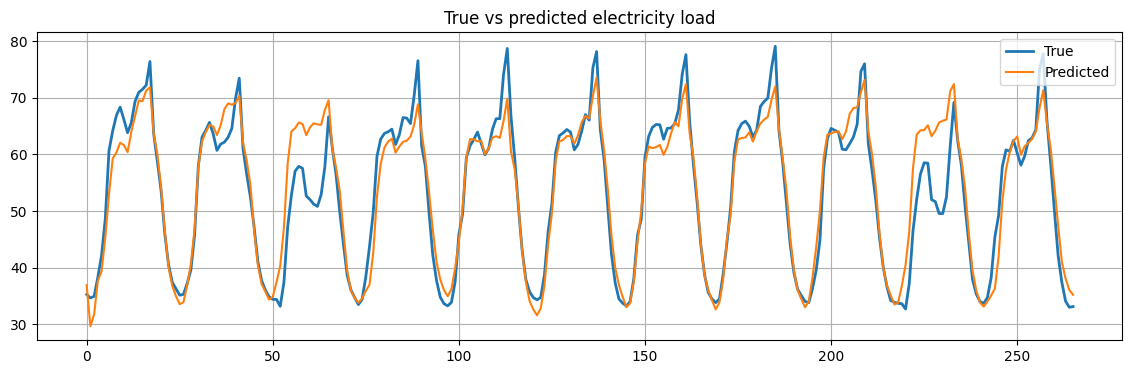

In [25]:
fig = plt.figure(figsize=(14,4))
plt.plot(Yte[n_drop:,:], label="True", linewidth=2)
plt.plot(scaler.inverse_transform(Yhat.reshape(-1, 1)), label="Predicted")
plt.grid()
plt.legend()
plt.title("True vs predicted electricity load")
plt.show()

In [26]:
mse_esn_original = mean_squared_error(scaler.inverse_transform(Yhat.reshape(-1, 1)), Yte[n_drop:,:])
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 28.04


### Уменьшение размерности состояний  

- Как обсуждалось ранее, государства-резервуары содержат богатый, но зачастую избыточный запас динамики. 
- Задача считывания состоит в том, чтобы выбрать только те динамики, которые полезны для поставленной задачи. 
- Однако обучение считывания на многомерных состояниях требует больших вычислительных ресурсов, особенно при использовании сложного считывания. 
- Кроме того, работа с данными большой размерности может увеличить риск мультиколлинеарности, которая дестабилизирует определенные модели, и переобучения.

- Может быть желательно уменьшить в некоторой степени избыточность в государствах-резервуарах. 
- Это можно сделать с помощью неконтролируемой процедуры уменьшения размерности. 
- Наиболее распространенной и эффективной процедурой снижения размерности является PCA.

#### Анализ главных компонентов (PCA) 
- PCA — это статистическая процедура, которая использует ортогональное преобразование для преобразования набора наблюдений возможно коррелирующих переменных в набор значений линейно некоррелированных переменных, называемых *главными компонентами*. 
- Число главных компонент меньше или равно числу исходных переменных. 
- Используя несколько компонентов, PCA уменьшает размерность больших наборов данных, проецируя данные в пространство меньшей размерности с минимальной потерей информации.

- Наши данные представляют собой последовательность состояний-резервуаров длины $T$, каждое из которых имеет размер $N_h$. 
- Их можно расположить в матрице $\mathbf{H} \in \mathbb{R}^{T \times N_h}$. 
- Чтобы проиллюстрировать процедуру, давайте сначала рассмотрим игрушечный пример всего с $N_h = 3$ функциями. 
- Кроме того, мы создадим некоторую структуру данных, разделив образцы на 4 группы/кластера. 
— Это поможет нам увидеть, как PCA сохраняет структуру данных.

In [ ]:
# Generate 4 clusters of points in 3 dimensions
T = 300 # number of samples
N_h = 3 # number of features
H, clust_id = make_blobs(n_samples=T, n_features=N_h,
                         centers=4, cluster_std=1.5, random_state=1)

In [ ]:
def plot_data(H, clust_id, interactive=False):
    if interactive:
        fig = go.Figure(data=[
            go.Scatter3d(x=H[:, 0], y=H[:, 1], z=H[:, 2], mode='markers',
            marker=dict(size=5, opacity=0.5, color=clust_id, colorscale='Viridis')),
        ])
        fig.update_layout(scene=dict(xaxis_title='X Axis',
                                     yaxis_title='Y Axis',
                                     zaxis_title='Z Axis',
                                     zaxis=dict(range=[-20, 10])),
                          margin=dict(l=0, r=0, b=0, t=0),
                          width=400, height=400
                        )
        fig.show()
    else:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter3D(xs=H[:, 0], ys=H[:, 1], zs=H[:, 2], linewidth=0.2, alpha=0.7, c=clust_id)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_zticks(())
        plt.show()

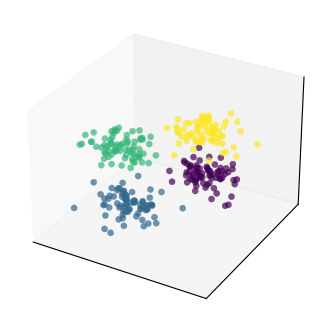

In [ ]:
# Set interactive = True to get an interactive plot that can be rotated
plot_data(H, clust_id, interactive=False)

Уменьшение размерности данных с помощью PCA включает следующие шаги: 

1. **Стандартизация** 
- Масштабируйте данные так, чтобы каждый признак имел среднее значение 0 и стандартное отклонение 1. 
- Это важно, поскольку на PCA влияет масштаб.

2. **Вычисление ковариационной матрицы**: 
- Вычислить эмпирическую ковариационную матрицу $\mathbf{H}^T\mathbf{H}$. 
- Матрица показывает, как изменения одной переменной связаны с изменениями другой переменной.

3. **Вычисление собственных значений и собственных векторов** 
- Собственные векторы ковариационной матрицы представляют собой направления максимальной дисперсии. 
- В контексте PCA собственные векторы являются основными компонентами. 
- Собственные значения указывают дисперсию, объясняемую каждым главным компонентом.

4. **Сортировка собственных векторов**: 

- Собственные векторы сортируются по убыванию собственных значений. 
— Выбираются верхние $k$ собственных векторов, где $k$ — количество измерений, которые мы хотим сохранить. 
- В нашем случае мы сохраняем размерности $k=2$.

5. **Проекция на новое пространство признаков**: 
- Исходные данные проецируются на выбранные главные компоненты. 
- В нашем случае трехмерные данные проецируются на плоскость, охватываемую первыми двумя главными компонентами. 
- Проецируемые данные представляют собой данные уменьшенного размера.

In [ ]:
# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
H_pca = pca.fit_transform(H)
v1, v2 = pca.components_

In [ ]:
def plot_pca_plane(H, clust_id, v1, v2, interactive=False):
    mean = np.mean(H, axis=0)
    length = np.linspace(-15, 15, 20)
    another_length = np.linspace(-15, 15, 20)
    xx, yy = np.meshgrid(length, another_length)

    def compute_z(x, y, v1, v2, mean):
        z = np.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                point_in_plane = mean + v1 * x[i, j] + v2 * y[i, j]
                z[i, j] = point_in_plane[2]
        return z
    Z_grid = compute_z(xx, yy, v1, v2, mean)

    if interactive:
        fig = go.Figure(data=[
            go.Surface(z=Z_grid, x=xx, y=yy, colorscale='gray', opacity=0.5, showscale=False),
            go.Scatter3d(x=H[:, 0], y=H[:, 1], z=H[:, 2], mode='markers',
                         marker=dict(size=5, opacity=0.5, color=clust_id, colorscale='Viridis'))])
        fig.update_layout(scene=dict(xaxis_title='X Axis',
                                     yaxis_title='Y Axis',
                                     zaxis_title='Z Axis',
                                     zaxis=dict(range=[-20, 20])),
                          margin=dict(l=0, r=0, b=0, t=0),
                          width=400, height=400)
        fig.show()
    else:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')

        surf = ax.plot_surface(xx, yy, Z_grid, cmap='gray', edgecolor='none', alpha=0.5)
        ax.scatter3D(xs=H[:, 0], ys=H[:, 1], zs=H[:, 2], linewidth=0.2, alpha=0.7, c=clust_id)
        ax.view_init(elev=20, azim=20)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_zticks(())
        plt.show()

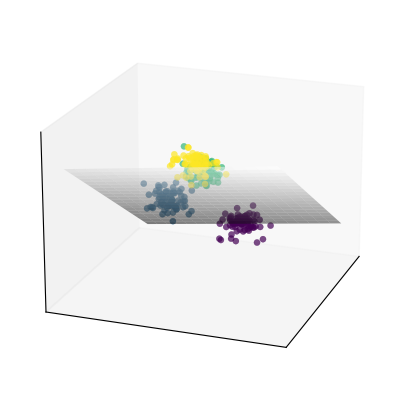

In [ ]:
# Plot the hyperplane spanned by the first two principal components
plot_pca_plane(H, clust_id, v1, v2, interactive=False)

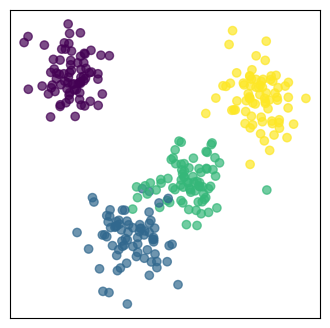

In [ ]:
# Plot the 2D projection
plt.figure(figsize=(4, 4))
plt.scatter(H_pca[:, 0], H_pca[:, 1], c=clust_id, cmap='viridis', alpha=0.7)
plt.xticks([], []), plt.yticks([], [])
plt.show()

- Мы можем еще больше уменьшить количество измерений. 
- В этом случае мы можем опуститься в 1 измерение. 
- Все сводится к проецированию данных в сторону максимального отклонения.

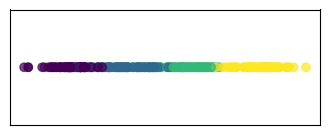

In [ ]:
H_pca_1d = PCA(n_components=1).fit_transform(H)

# Plot the 1D projection
plt.figure(figsize=(4, 1.5))
plt.scatter(H_pca_1d, np.zeros_like(H_pca_1d), c=clust_id, cmap='viridis', alpha=0.7)
plt.xticks([], []), plt.yticks([], [])
plt.show()

- 💡 Посетите [этот блог](https://setosa.io/ev/principal-comComponent-anaанализ/) для получения превосходного визуального объяснения и интерактивных примеров о PCA.

#### Уменьшение размерности состояний Резервуара 

- Давайте вернемся к нашим состояниям, которые в нашем случае являются векторами очень высокой размерности. 
- В частности, поскольку `n_internal_units=900`, мы получаем последовательность векторов длиной `T` и размером `900`. 
- Мы будем использовать PCA, чтобы уменьшить размерность состояний резервуара до «75».

In [ ]:
pca = PCA(n_components=75)
states_tr_pca = pca.fit_transform(states_tr[0])
states_te_pca = pca.transform(states_te[0])
print(f"states_tr shape: {states_tr_pca.shape}\nstates_te shape: {states_te_pca.shape}")

states_tr shape: (2666, 75)
states_te shape: (266, 75)


- Ниже мы подгоняем показания к новым данным и вычисляем результаты на тестовом наборе.

In [ ]:
# Fit the ridge regression model
ridge = Ridge(alpha=1.0)
time_start = time.time()
ridge.fit(states_tr_pca, Ytr[n_drop:,:])
print(f"Training time: {time.time()-time_start:.4f}s")

# Compute the predictions
time_start = time.time()
Yhat_pca = ridge.predict(states_te_pca)
print(f"Test time: {time.time()-time_start:.4f}s")

# Compute the mean squared error
mse = mean_squared_error(scaler.inverse_transform(Yhat_pca.reshape(-1, 1)), Yte[n_drop:,:])
print(f"Mean Squared Error: {mse:.2f}")

Training time: 0.0028s
Test time: 0.0001s
Mean Squared Error: 22.55


- Даже при резком уменьшении размерности производительность осталась более-менее неизменной. 
— С другой стороны, мы сокращаем время вычислений как при обучении, так и при тестировании. 
- Это сокращение времени вычислений особенно существенно при использовании более сложных считываний, подобных тому, которое мы попробуем дальше.

### Установите показания GBRT 

- Сопоставление состояний резервуара с желаемыми выходными данными — это стандартная задача регрессии, которую можно решить с помощью одной из многих стандартных моделей регрессии в [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html). 
- Например, мы можем использовать дерево регрессии градиентного повышения (GBRT), которое дает нам прогнозы для различных квантилей. 
- Таким образом, мы можем вычислить доверительные интервалы в наших прогнозах. 
— Это очень простой способ реализовать вероятностное прогнозирование.

- Далее мы будем использовать другую модель для квантилей 0,5, 0,05 и 0,95. 
- Квантиль 0,5 даст нам наиболее вероятный прогноз будущих значений. 
- Квантили 0,05 и 0,95 вместе дают 90% доверительный интервал для нашего прогноза.

In [ ]:
time_start = time.time()

# Quantile 0.5
max_iter = 100
gbrt_median = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.5, max_iter=max_iter)
gbrt_median.fit(states_tr[0], Ytr[n_drop:,0])
median_predictions = gbrt_median.predict(states_te[0])

# Quantile 0.05
gbrt_percentile_5 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.05, max_iter=max_iter)
gbrt_percentile_5.fit(states_tr[0], Ytr[n_drop:,0])
percentile_5_predictions = gbrt_percentile_5.predict(states_te[0])

# Quantile 0.95
gbrt_percentile_95 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.95, max_iter=max_iter)
gbrt_percentile_95.fit(states_tr[0], Ytr[n_drop:,0])
percentile_95_predictions = gbrt_percentile_95.predict(states_te[0])

print(f"Training time: {time.time()-time_start:.2f}s")

Training time: 11.51s


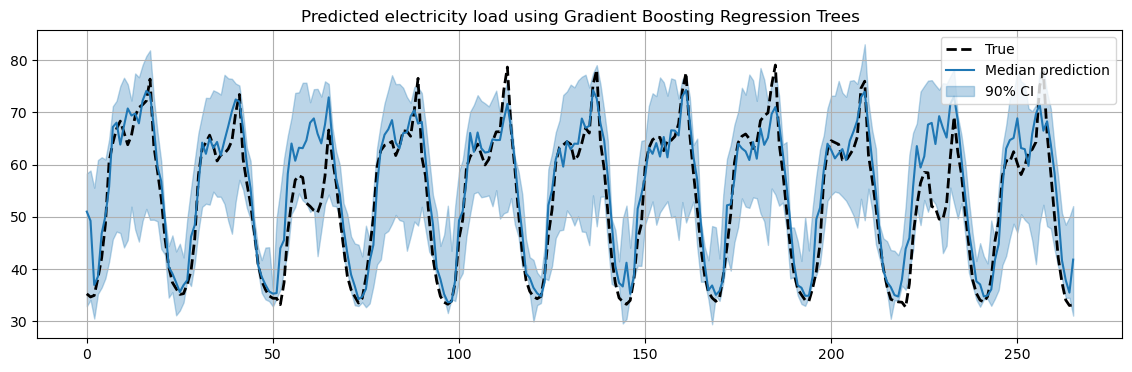

In [ ]:
# Plot the results
fig = plt.figure(figsize=(14,4))
plt.plot(Yte[n_drop:,:], 'k--', label="True", linewidth=2)
plt.plot(scaler.inverse_transform(median_predictions[:,None]), label="Median prediction", color="tab:blue")
plt.fill_between(np.arange(len(Yte[n_drop:,:])), scaler.inverse_transform(percentile_5_predictions[:,None]).ravel(), scaler.inverse_transform(percentile_95_predictions[:,None]).ravel(), alpha=0.3, label="90% CI", color="tab:blue")
plt.grid()
plt.legend()
plt.title("Predicted electricity load using Gradient Boosting Regression Trees")
plt.show()

- Наконец, повторяем обучение на состояниях, уменьшенных с помощью PCA.

In [ ]:
time_start = time.time()

# Quantile 0.5
max_iter = 100
gbrt_median = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.5, max_iter=max_iter)
gbrt_median.fit(states_tr_pca, Ytr[n_drop:,0])
median_predictions = gbrt_median.predict(states_te_pca)

# Quantile 0.05
gbrt_percentile_5 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.05, max_iter=max_iter)
gbrt_percentile_5.fit(states_tr_pca, Ytr[n_drop:,0])
percentile_5_predictions = gbrt_percentile_5.predict(states_te_pca)

# Quantile 0.95
gbrt_percentile_95 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.95, max_iter=max_iter)
gbrt_percentile_95.fit(states_tr_pca, Ytr[n_drop:,0])
percentile_95_predictions = gbrt_percentile_95.predict(states_te_pca)

print(f"Training time: {time.time()-time_start:.2f}s")

Training time: 5.80s


- Улучшение с точки зрения вычислительного времени теперь является значительным.

## Резюме 

На этой лекции мы увидели: 

- Нейронные сети, MLP и то, как его можно использовать в качестве оконной модели для прогнозирования временных рядов. 
- Ограничения оконных подходов и способы их решения с помощью RNN. 
- ESN, рандомизированная RNN из семейства Reservoir Computing, которая быстро и легко обучается. 
- Примеры прогнозирования с помощью MLP и ESN на основе реальных данных об электроэнергии. 

---

## Упражнения 

### Упражнение 1 

- В примере MLP измените `window_size` ($P$) с 12 на 24. 
- Прокомментируйте результаты и объясните, почему производительность улучшилась.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.datasets import make_circles
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.utils import make_forecasting_dataset
from reservoir_computing.datasets import PredLoader

In [2]:
ts_full = PredLoader().get_data('ElecRome')

# Resample the time series to hourly frequency
ts_hourly = np.mean(ts_full.reshape(-1, 6), axis=1)

# Use only the first 3000 time steps
time_series = ts_hourly[0:3000]
time_steps = np.arange(0, len(time_series))

Loaded ElecRome dataset.
Data shape:
  X: (137376, 1)


In [4]:
# Split the time series into training and test sets
train_size = int(0.9*len(time_series))
tr = time_series[:train_size]
te = time_series[train_size:]

def create_windows(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

# Define window size and forecast horizon
window_size = 24
forecast_horizon = 12

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

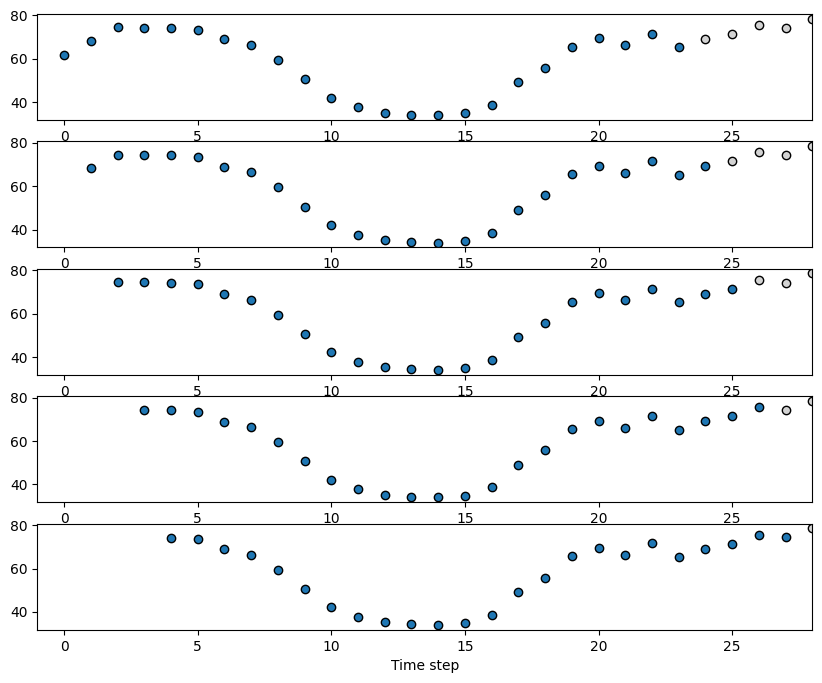

In [5]:
# Plot some pairs of input-output
fig, axes = plt.subplots(5,1,figsize=(10,8))
for i in range(5):
    axes[i].scatter(range(i, window_size+i), X_train[i], color='tab:blue', edgecolor='k')  # Input
    axes[i].scatter(range(window_size+i, i+window_size+forecast_horizon-1), y_train[i,:-1], color='lightgray', edgecolor='k')
    axes[i].scatter(i+window_size+forecast_horizon-1, y_train[i,-1], color='tab:orange', edgecolor='k')
    axes[i].set_xlim(-1,28)
plt.xlabel('Time step')
plt.show()

### Упражнение 2 
— В MLP измените «forecast_horizon» с 24 на 36. 
- Сделайте то же самое и в ESN. 
- С горизонтом прогноза размером 24 мы использовали в качестве бейзлайна MSE между временным рядом и его версией, смещенной на 24 лага, `mse =mean_squared_error(y_test[24:], y_test[:-24])`. Является ли это хорошей базой даже при изменении горизонта прогнозирования? Что может быть лучшим базлайном?

In [8]:
# Split the time series into training and test sets
train_size = int(0.9*len(time_series))
tr = time_series[:train_size]
te = time_series[train_size:]



# Define window size and forecast horizon
window_size = 12
forecast_horizon = 36

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)


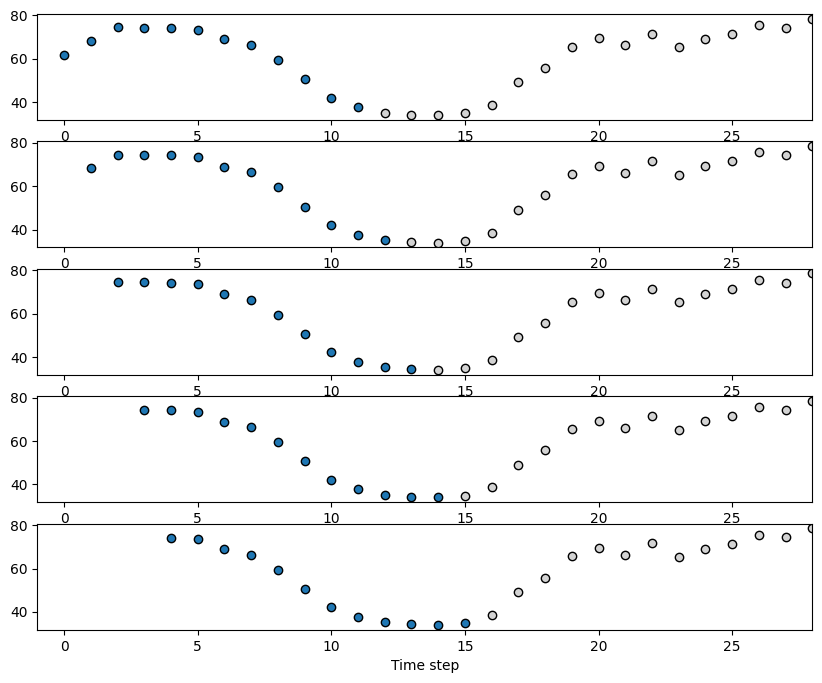

In [9]:
# Plot some pairs of input-output
fig, axes = plt.subplots(5,1,figsize=(10,8))
for i in range(5):
    axes[i].scatter(range(i, window_size+i), X_train[i], color='tab:blue', edgecolor='k')  # Input
    axes[i].scatter(range(window_size+i, i+window_size+forecast_horizon-1), y_train[i,:-1], color='lightgray', edgecolor='k')
    axes[i].scatter(i+window_size+forecast_horizon-1, y_train[i,-1], color='tab:orange', edgecolor='k')
    axes[i].set_xlim(-1,28)
plt.xlabel('Time step')
plt.show()

**Является ли это хорошей базой даже при изменении горизонта прогнозирования? Что может быть лучшим базлайном?**

Нет. Это хороший baseline только если горизонт совпадает с сезонностью (например, 24 часа при суточной периодичности). При изменении горизонта такой сдвиг уже не является корректным сравнением.

Лучше использовать:

Naive baseline: прогноз = последнее наблюдение окна.

Seasonal naive: прогноз = значение прошлого сезона (если есть выраженная сезонность).

Иногда — скользящее среднее или простой ARIMA(0,1,0).

### Упражнение 3 

В отличие от подхода, основанного на моделях, такого как ARIMA, MLP и ESN строго не требуют, чтобы данные были стационарными. Однако, устранив тренд и сезонность, MLP и ESN могут сосредоточиться только на прогнозировании остатков. 

- Удалите тренд и сезонность и обучите MLP и ESN обучению остатков. 
- При тестировании не забывайте учитывать тенденцию и сезонность при расчете прогнозов. 
- Сравните результаты с результатами, полученными при обучении MLP и ESN на исходных данных.

In [44]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.datasets import make_circles
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.utils import make_forecasting_dataset
from reservoir_computing.datasets import PredLoader
from statsmodels.tsa.seasonal import seasonal_decompose


ts_full = PredLoader().get_data('ElecRome')

# 10-min → hourly
ts_hourly = np.mean(ts_full.reshape(-1, 6), axis=1)

# use first 3000 points
time_series = ts_hourly[:3000]

train_size = int(0.9 * len(time_series))
tr = time_series[:train_size]
te = time_series[train_size:]



period = 24

decomp = seasonal_decompose(tr, model='additive', period=period)

trend_tr = decomp.trend
seasonal_tr = decomp.seasonal
resid_tr = decomp.resid

# убираем nan по краям
valid_idx = ~np.isnan(resid_tr)
trend_tr = trend_tr[valid_idx]
seasonal_tr = seasonal_tr[valid_idx]
resid_tr = resid_tr[valid_idx]

# Сезонный паттерн на 24 часа
season_pattern = seasonal_tr[:period]

# Тренд аппроксимируем линейной регрессией
t = np.arange(len(trend_tr))
coef = np.polyfit(t, trend_tr, 1)
trend_model = np.poly1d(coef)


Loaded ElecRome dataset.
Data shape:
  X: (137376, 1)


In [45]:
def create_windows(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])
    return np.array(X), np.array(y)

window_size = 24
forecast_horizon = 24


# обучение MLP на остатках

X_train, y_train = create_windows(resid_tr, window_size, forecast_horizon)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

mlp_res = MLPRegressor(hidden_layer_sizes=(32,16),
                       activation='relu',
                       solver='adam',
                       max_iter=1000)

mlp_res.fit(X_train_scaled, y_train)


,loss,'squared_error'
,hidden_layer_sizes,"(32, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True


In [46]:
# Прогноз MLP с восстановлением тренда и сезонности

# формируем остатки теста
full_series = np.concatenate([tr, te])

# тренд для всего ряда
t_full = np.arange(len(full_series))
trend_full = trend_model(t_full)

# сезонность повторяем
season_full = np.tile(season_pattern,
                      len(full_series)//period + 1)[:len(full_series)]

residual_full = full_series - trend_full - season_full

resid_te = residual_full[train_size:]

X_test, y_test = create_windows(resid_te, window_size, forecast_horizon)
X_test_scaled = scaler.transform(X_test)

# прогноз остатка
y_pred_res = mlp_res.predict(X_test_scaled)

# восстанавливаем полный прогноз
start_idx = train_size + window_size + forecast_horizon - 1
trend_pred = trend_full[start_idx:start_idx+len(y_pred_res)]
season_pred = season_full[start_idx:start_idx+len(y_pred_res)]

y_pred_mlp = y_pred_res + trend_pred + season_pred

# истинные значения
y_true = full_series[start_idx:start_idx+len(y_pred_res)]

mse_mlp_res = mean_squared_error(y_true, y_pred_mlp)
print(f"MLP (residual training) MSE: {mse_mlp_res:.2f}")


MLP (residual training) MSE: 127.37


In [47]:
# =========================
# ESN
# =========================

resid_tr_2d = resid_tr[:, None]
resid_te_2d = resid_te[:, None]

res = Reservoir(n_internal_units=900,
                spectral_radius=0.99,
                input_scaling=0.1,
                connectivity=0.25)

n_drop = 10

states_tr = res.get_states(resid_tr_2d[None,:,:],
                           n_drop=n_drop,
                           bidir=False)

states_te = res.get_states(resid_te_2d[None,:,:],
                           n_drop=n_drop,
                           bidir=False)

ridge = Ridge(alpha=1.0)
ridge.fit(states_tr[0], resid_tr_2d[n_drop:])

Yhat_res = ridge.predict(states_te[0])



In [52]:
Yhat_res_flat = Yhat_res.flatten()

trend_pred_esn = trend_full[train_size+n_drop:
                            train_size+n_drop+len(Yhat_res_flat)]

season_pred_esn = season_full[train_size+n_drop:
                              train_size+n_drop+len(Yhat_res_flat)]

y_pred_esn = Yhat_res_flat + trend_pred_esn + season_pred_esn

y_true_esn = full_series[train_size+n_drop:
                         train_size+n_drop+len(Yhat_res_flat)]

mse_esn_res = mean_squared_error(y_true_esn, y_pred_esn)
print(f"ESN (residual training) MSE: {mse_esn_res:.2f}")


ESN (residual training) MSE: 0.80


In [53]:
print("Baseline MLP MSE:", mse_mlp_original)
print("Residual MLP MSE:", mse_mlp_res)

print("Baseline ESN MSE:", mse_esn_original)
print("Residual ESN MSE:", mse_esn_res)


Baseline MLP MSE: 28.04436954577414
Residual MLP MSE: 127.37319601033556
Baseline ESN MSE: 19.710185590222892
Residual ESN MSE: 0.7985713988551126


28 → 131 — это деградация в ~4.5 раза.
Это не нормально.


* После удаления детерминированной структуры в остатках осталась в основном шумовая + сложная автокорреляция.

* MLP с окном 24 плохо вытаскивает такую динамику.

* Плюс остатки могли стать менее масштабно-устойчивыми.

### Упражнение 4 

В этом упражнении мы рассмотрим новый набор данных, состоящий из почасовых значений температуры воды в Мексиканском заливе недалеко от Ки-Уэста, Флорида. 
Почасовые температуры указаны с 3 октября 2016 г. по 3 октября 2017 г. 
Набор данных состоит из кадра данных с 6572 наблюдениями по следующим трем переменным. 

- `DateTime` Дата и время чтения (формат мм/дд/гггг ч:м). 
- «WaterTemp»: температура воды (в градусах Фаренгейта). 
- `t`: индекс времени (от 1 до 673).

Raw data:
------------------
          DateTime  WaterTemp  t
0  10/3/2016 0:00       86.2  1
1  10/3/2016 1:00       86.2  2
2  10/3/2016 2:00       86.2  3
3  10/3/2016 3:00       86.2  4
4  10/3/2016 4:00       86.0  5


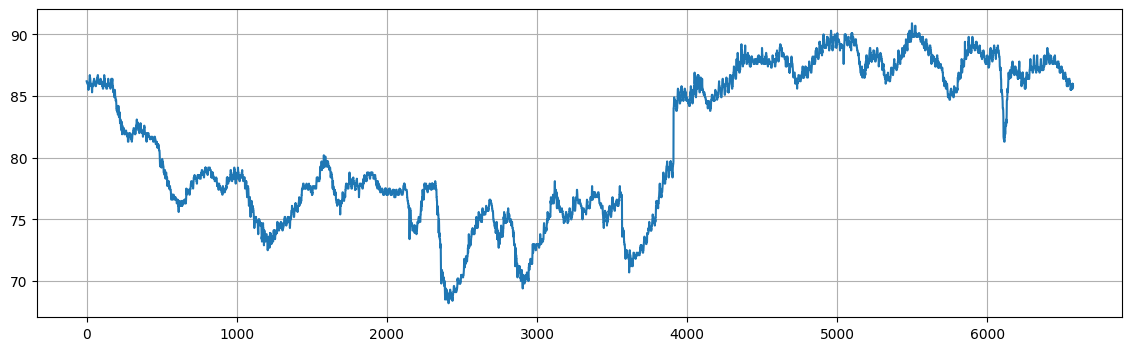

In [55]:
temps = sm.datasets.get_rdataset("KeyWestWater", "Stat2Data").data
print("Raw data:\n------------------\n", temps.head())
plt.figure(figsize=(14,4))
plt.plot(temps["WaterTemp"])
plt.grid()
plt.show()

- Примените MLP к данным температуры. 
- Выполните поиск по небольшой сетке, чтобы попробовать разные значения для следующих гиперпараметров: 
- `hidden_layer_sizes` (например, попробуйте больше слоев `[16, 16, 8]`, слоев с большим количеством блоков `[32, 16]` и т. д.). 
- `learning_rate_init`. 
- «активация» (попробуйте хотя бы «tanh» и «relu»). 
- Примените ESN к данным температуры. 
- Выполните поиск по небольшой сетке, чтобы попробовать разные значения для следующих гиперпараметров: 
- `спектральный_радиус`. 
- `input_scaling`. 
- `n_internal_units`. 
- `связность`. 

Сообщите о конфигурации MLP и ESN, которая обеспечивает наилучшую производительность на тестовых данных.

In [56]:
# ===============================
# Train/test split
# ===============================
series = temps["WaterTemp"].values

train_size = int(0.9 * len(series))
tr = series[:train_size]
te = series[train_size:]

In [57]:
def create_windows(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])
    return np.array(X), np.array(y)

window_size = 24
forecast_horizon = 24


In [58]:
from sklearn.model_selection import ParameterGrid
# MLP
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



mlp_param_grid = {
    "hidden_layer_sizes": [(16,16,8), (32,16), (64,32)],
    "learning_rate_init": [0.001, 0.0005],
    "activation": ["relu", "tanh"]
}

best_mlp_mse = np.inf
best_mlp_config = None

for params in ParameterGrid(mlp_param_grid):
    
    mlp = MLPRegressor(
        hidden_layer_sizes=params["hidden_layer_sizes"],
        learning_rate_init=params["learning_rate_init"],
        activation=params["activation"],
        max_iter=1000,
        random_state=42
    )
    
    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"MLP {params} → MSE: {mse:.4f}")
    
    if mse < best_mlp_mse:
        best_mlp_mse = mse
        best_mlp_config = params

print("\nBest MLP configuration:")
print(best_mlp_config)
print("Best MLP Test MSE:", best_mlp_mse)


MLP {'activation': 'relu', 'hidden_layer_sizes': (16, 16, 8), 'learning_rate_init': 0.001} → MSE: 2.2711
MLP {'activation': 'relu', 'hidden_layer_sizes': (16, 16, 8), 'learning_rate_init': 0.0005} → MSE: 1.9827
MLP {'activation': 'relu', 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.001} → MSE: 1.8725
MLP {'activation': 'relu', 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.0005} → MSE: 1.9371
MLP {'activation': 'relu', 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001} → MSE: 1.9092
MLP {'activation': 'relu', 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.0005} → MSE: 1.8756
MLP {'activation': 'tanh', 'hidden_layer_sizes': (16, 16, 8), 'learning_rate_init': 0.001} → MSE: 46.8019
MLP {'activation': 'tanh', 'hidden_layer_sizes': (16, 16, 8), 'learning_rate_init': 0.0005} → MSE: 46.7243
MLP {'activation': 'tanh', 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.001} → MSE: 2.0631
MLP {'activation': 'tanh', 'hidden_layer_sizes': (32, 16), 'lear

In [59]:

#  ESN


tr_2d = tr[:, None]
te_2d = te[:, None]

best_esn_mse = np.inf
best_esn_config = None

esn_param_grid = {
    "spectral_radius": [0.8, 0.95, 0.99],
    "input_scaling": [0.05, 0.1, 0.5],
    "n_internal_units": [300, 600, 900],
    "connectivity": [0.1, 0.25]
}

for params in ParameterGrid(esn_param_grid):
    
    res = Reservoir(
        n_internal_units=params["n_internal_units"],
        spectral_radius=params["spectral_radius"],
        input_scaling=params["input_scaling"],
        connectivity=params["connectivity"]
    )
    
    n_drop = 10
    
    states_tr = res.get_states(tr_2d[None,:,:], n_drop=n_drop, bidir=False)
    states_te = res.get_states(te_2d[None,:,:], n_drop=n_drop, bidir=False)
    
    ridge = Ridge(alpha=1.0)
    ridge.fit(states_tr[0], tr_2d[n_drop:])
    
    Yhat = ridge.predict(states_te[0])
    
    mse = mean_squared_error(te_2d[n_drop:], Yhat)
    
    print(f"ESN {params} → MSE: {mse:.4f}")
    
    if mse < best_esn_mse:
        best_esn_mse = mse
        best_esn_config = params

print("\nBest ESN configuration:")
print(best_esn_config)
print("Best ESN Test MSE:", best_esn_mse)


ESN {'connectivity': 0.1, 'input_scaling': 0.05, 'n_internal_units': 300, 'spectral_radius': 0.8} → MSE: 2.4901
ESN {'connectivity': 0.1, 'input_scaling': 0.05, 'n_internal_units': 300, 'spectral_radius': 0.95} → MSE: 1.7850
ESN {'connectivity': 0.1, 'input_scaling': 0.05, 'n_internal_units': 300, 'spectral_radius': 0.99} → MSE: 0.6417
ESN {'connectivity': 0.1, 'input_scaling': 0.05, 'n_internal_units': 600, 'spectral_radius': 0.8} → MSE: 1.5638
ESN {'connectivity': 0.1, 'input_scaling': 0.05, 'n_internal_units': 600, 'spectral_radius': 0.95} → MSE: 1.1047
ESN {'connectivity': 0.1, 'input_scaling': 0.05, 'n_internal_units': 600, 'spectral_radius': 0.99} → MSE: 0.6498
ESN {'connectivity': 0.1, 'input_scaling': 0.05, 'n_internal_units': 900, 'spectral_radius': 0.8} → MSE: 1.2860
ESN {'connectivity': 0.1, 'input_scaling': 0.05, 'n_internal_units': 900, 'spectral_radius': 0.95} → MSE: 0.1412
ESN {'connectivity': 0.1, 'input_scaling': 0.05, 'n_internal_units': 900, 'spectral_radius': 0.99} 